Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


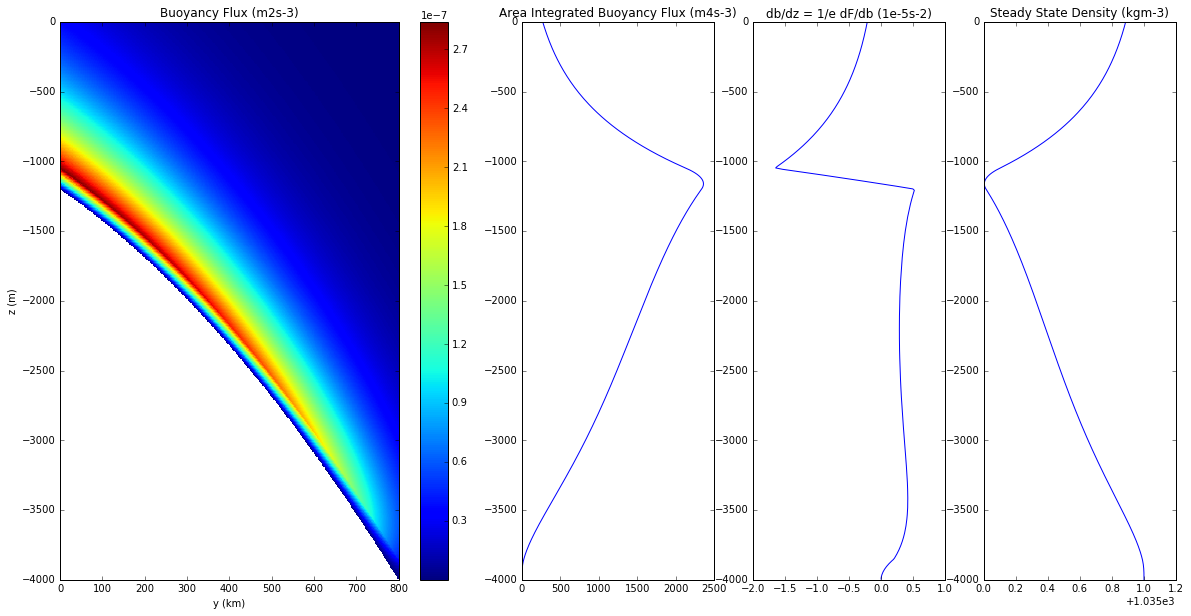

In [88]:
%pylab inline
import numpy as np
import matplotlib.pyplot as plt

# Analytical Steady State Solution:
# Parameters:
B0 = 0.3e-6; hBL = 150.0; d = 500.0; r = 1000.0; eps = 0.25e6; rho0 = 1035.0; g = 9.81;
H = 4000; drho = 1.0; W = 40.0e3; L = 800.0e3; Ny = 1600; Nz = 400;
# Analytical Grid:
y = np.linspace(0,L,Ny); z = np.linspace(-H,0,Nz); dy = y[1]-y[0]; dz = z[1]-z[0]
[Z,Y] = np.meshgrid(z,y); [yLa, zLa] = np.shape(Y)

# Topography:
#Parabolic:
bwidth = 0.0; idepth=0.3; curv = 0.4;
yb = 1.0-bwidth; ah = idepth*H; ch = curv*(H-ah)/yb/yb; bh = (H-ah-ch*yb*yb)/yb;
h = np.zeros(np.shape(y)); h[y/L>=yb] = H; h[y/L<yb] = ah + bh*y[y/L<yb]/L + ch/L/L*np.power(y[y/L<yb],2); h = -h
#Circular:
#bwidth = 0.0; idepth=0.0; R = 100000.0e3;
#y1 = 0.0; y2 = (1.0-bwidth)*L; z1 = idepth*H; z2 = -H;
#A = ((y1**2-y2**2)-(z1**2-z2**2))/2/(y1-y2);B = (z1-z2)/(y1-y2);
#b = -2*z1+2*(y1-A)*B; a = B**2+1; c = (y1-A)**2+z1**2-R**2;
#cz = (-b+np.sqrt(b**2-4*a*c))/2/a;cy = A-cz*B;
#h = np.zeros(np.shape(y));h = -np.sqrt(R**2-(y-cy)**2)+cz 
#Logarithmic:
#bwidth = 0.0; idepth = 0.0; b = 2.0;
#yb = 1.0-bwidth; zt = idepth*H; c = (H -zt*np.log(b-1.0)/np.log(b))/(1.0-np.log(b-1.0)/np.log(b)); a = (zt-c)/np.log(b)
#h = np.zeros(np.shape(y)); h[y/L>=yb] = H; h[y/L<yb] = a*np.log(b-y[y/L<yb]/yb/L)+c; h = -h;

h2D = np.tile(h,[zLa,1]).T
# Buoyancy Flux:
B = np.ma.zeros(np.shape(Y))
B[np.logical_and(Z>=h2D,Z<=h2D+hBL)] = B0*(Z[np.logical_and(Z>=h2D,Z<=h2D+hBL)]-h2D[np.logical_and(Z>=h2D,Z<=h2D+hBL)])/hBL
B[Z>h2D+hBL] = B0*np.exp(-(Z[Z>h2D+hBL]-h2D[Z>h2D+hBL]-hBL)/d)
B = B*(1-np.exp(-(Z+H)/r)); B = np.ma.masked_where(Z<=h2D,B)
# Area Integrated B, dbdz, drhodz, rho:
F = np.ma.sum(B,axis=0)*dy*W; F[0]=0.0; F.mask[0] = False; dbdz = np.ma.diff(F)/dz/eps; drhodz = -rho0/g*dbdz
rho = np.zeros(np.shape(z)); rho[0] = rho0+drho; rho[1:] = np.cumsum(drhodz)*dz+rho[0]
# Plotting:
f = plt.figure(figsize=(20,10))
plt.subplot2grid((1,5),(0,0), colspan=2);
plt.pcolormesh(Y/1e3,Z,B);plt.xlabel('y (km)');plt.ylabel('z (m)');plt.title('Buoyancy Flux (m2s-3)');plt.colorbar()
plt.subplot(1,5,3);plt.plot(F,z);plt.title('Area Integrated Buoyancy Flux (m4s-3)');
plt.subplot(1,5,4);plt.plot(dbdz/1.0e-5,(z[:-1]+z[1:])/2);plt.title('db/dz = 1/e dF/db (1e-5s-2)');
plt.subplot(1,5,5);plt.plot(rho,z);plt.title('Steady State Density (kgm-3)');

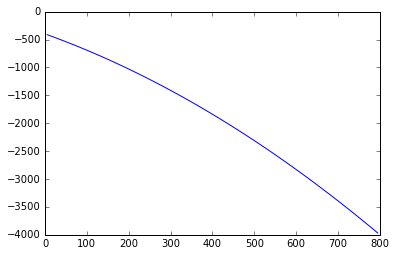

In [86]:
# Save 2D topography into netcdf file for input into MOM6:
import netCDF4 as nc
import os
nx = 4; ny = 80; L = 800.0; H = 4000.0; nhalo = 4;
y = np.linspace(0,L-L/ny,ny)+L/ny/2

#---------------------------------------------------------------------
outname = "INPUT/topog.nc"
#Parabolic:
bwidth = 0.0; idepth=0.1; curv = 0.4;
yb = 1.0-bwidth; ah = idepth*H; ch = curv*(H-ah)/yb/yb; bh = (H-ah-ch*yb*yb)/yb;
h = np.zeros(np.shape(y)); h[y/L>=yb] = H; h[y/L<yb] = ah + bh*y[y/L<yb]/L + ch/L/L*np.power(y[y/L<yb],2); 

#---------------------------------------------------------------------
plt.plot(y,-h)
#Create netcdf:
try:
    os.remove(outname)
except OSError:
    pass
ncobj = nc.Dataset(outname, "w", format="NETCDF3_64BIT_OFFSET")
ntilesob = ncobj.createDimension("ntiles", 1)
nxob = ncobj.createDimension("nx", nx)
nyob = ncobj.createDimension("ny", ny)
hob  = ncobj.createVariable("depth","f8",("ny","nx"))
hob.standard_name = "topographic depth at T-cell centers"
hob.units = "meters"
hob[:] = np.tile(h,(nx,1)).T
ncobj.close()